In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [3]:
with open('data/pv_forecast.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [7]:
pv = pv.set_index('datetime')

In [8]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [9]:
from torch.utils.data import DataLoader, Dataset

In [10]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y_src = np.zeros([output_window, num_samples, num_feature])
        Y_tgt = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]

            start_y = stride*i + input_window 
            end_y = start_y + output_window 
            Y_src[:,i] = y[(start_y-1):(end_y-1)]
            Y_tgt[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y_src = Y_src.reshape(Y_src.shape[0], Y_src.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, feature)
        Y_tgt = Y_tgt.reshape(Y_tgt.shape[0], Y_tgt.shape[1], num_feature).transpose((1,0,2))
        self.x = X[:,:-1,:]
        self.y_src = Y_src
        self.y_tgt = Y_tgt
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y_src[i], self.y_tgt[i]

    def __len__(self):
        return self.len

In [11]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = windowDataset(pv_train[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = windowDataset(pv_test[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=4)

In [12]:
len(train_loader)

22

In [13]:
len(test_loader)

3

# transformer

- 시계열 데이터 transformer 적용이 목표이기 때문에 최대한 간단한 구조로 적용

- positional embedding 적용 x

- encoder, decoder 모두 1개의 layer

- target seq의 경우 teacher force prop 1/0 두가지로 적용

In [14]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim

from tqdm.auto import tqdm

In [72]:
class transformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward): # num_layers: lstm layer 수
        super(transformer, self).__init__() 
        # self.d_model = d_model

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, 
                                          num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, 
                                          batch_first=True)
        self.linear = nn.Linear(d_model, 1)

    def forward(self, x, y, tgt_mask):
        output = self.transformer(x, y, tgt_mask=tgt_mask)
        out = self.linear(output)
        return out, output


# teacher forcing = 1

In [73]:
def train(train_loader, tgt_mask, epochs=10):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0

        for x, y_in, y_out in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y_in = y_in.to(device).float()
            y_out = y_out.to(device).float()
            # output, attention = model(x, y_in, tgt_mask=tgt_mask).to(device)
            output, attention = model(x, y_in, tgt_mask=tgt_mask)
            # print(output.shape)
            loss = criterion(output[:,:,0], y_out[:,:,0])
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss=f"{(total_loss/len(train_loader)):.5f}")

    return output, attention

In [74]:
def predict(test_loader, tgt_mask, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    for t, (x, y_in, y_out) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()
        output = model(x, y_in, tgt_mask=tgt_mask).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y_out[:,:,0])
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[]))

In [75]:
device='cpu'
model = transformer(d_model=5, nhead=5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128).to(device)

learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [76]:
# target_mask = model.generate_square_subsequent_mask(24).to(device)
pred_train, attention_train = train(train_loader, tgt_mask=None, epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

In [86]:
attention_train.shape

torch.Size([12, 24, 5])

In [88]:
attention_train.mean(axis=0).shape

torch.Size([24, 5])

In [81]:
attention_layer = "transformer.decoder.norm.weight"

In [80]:
for name, p in model.named_parameters():
	print(name)

transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight
transformer.encoder.layers.0.linear2.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layers.0.norm1.bias
transformer.encoder.layers.0.norm2.weight
transformer.encoder.layers.0.norm2.bias
transformer.encoder.norm.weight
transformer.encoder.norm.bias
transformer.decoder.layers.0.self_attn.in_proj_weight
transformer.decoder.layers.0.self_attn.in_proj_bias
transformer.decoder.layers.0.self_attn.out_proj.weight
transformer.decoder.layers.0.self_attn.out_proj.bias
transformer.decoder.layers.0.multihead_attn.in_proj_weight
transformer.decoder.layers.0.multihead_attn.in_proj_bias
transformer.decoder.layers.0.multihead_attn.out_proj.weigh

In [82]:
for name, p in model.named_parameters():
  if name==attention_layer:
    print(p.shape)
	# print(name)

torch.Size([5])


In [85]:
attention.shape

NameError: ignored

In [ ]:
pred, true = predict(test_loader, tgt_mask=target_mask)

test loss: 0.01459


In [ ]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [ ]:
pred.shape

(216, 1)

In [ ]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

In [ ]:
pv_test.shape

(216, 19)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


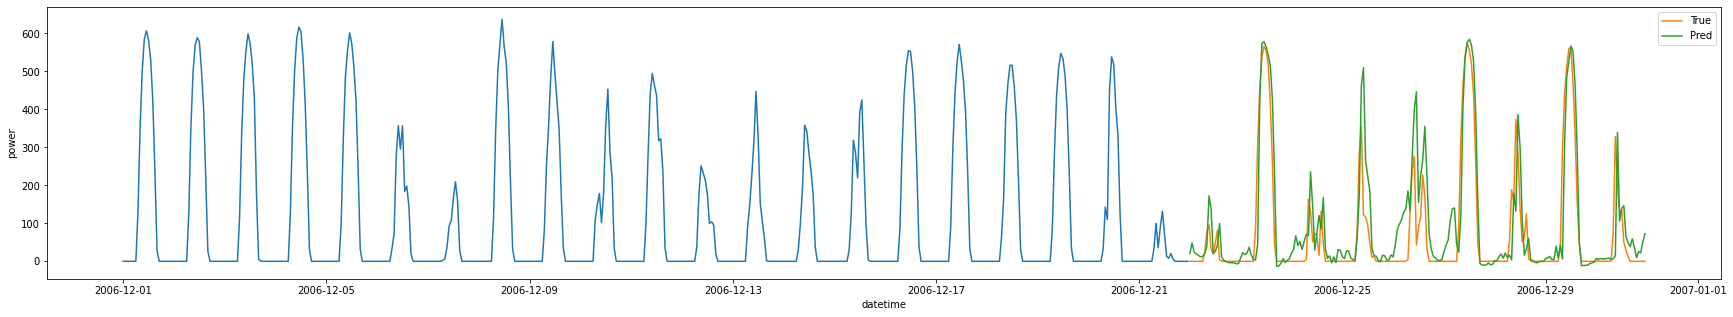

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

# teacher forcing 0

In [ ]:
def train(train_loader, tgt_mask, max_len, epochs=10):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0

        for x, y_in, y_out in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y_in = y_in.to(device).float()
            y_out = y_out.to(device).float()
            # print(y_in.shape)

            for t in range(max_len):
                y_in_temp = y_in[:,:(t+1),:]
                output = model(x, y_in_temp, tgt_mask=tgt_mask).to(device)
                if t < (max_len-1):
                    y_in[:,1:(t+2),:] = output[:,:(t+1),:]
            loss = criterion(output[:,:,0], y_out[:,:,0])
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss=f"{(total_loss/len(train_loader)):.5f}")

In [ ]:
def predict(test_loader, tgt_mask, max_len, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    for t, (x, y_in, y_out) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()


        for t in range(max_len):
            y_in_temp = y_in[:,:(t+1),:]
            output = model(x, y_in_temp, tgt_mask=tgt_mask).to(device)
            if t < (max_len-1):
                y_in[:,1:(t+2),:] = output[:,:(t+1),:]
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y_out[:,:,0])
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[]))

In [ ]:
device='cuda'
model = nn.Transformer(d_model=5, nhead=5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128, batch_first=True).to(device)

learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [ ]:
target_mask = model.generate_square_subsequent_mask(24).to(device)
train(train_loader, tgt_mask=None, max_len=24, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
pred, true = predict(test_loader, tgt_mask=None, max_len=24)

test loss: 0.03283


In [ ]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [ ]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


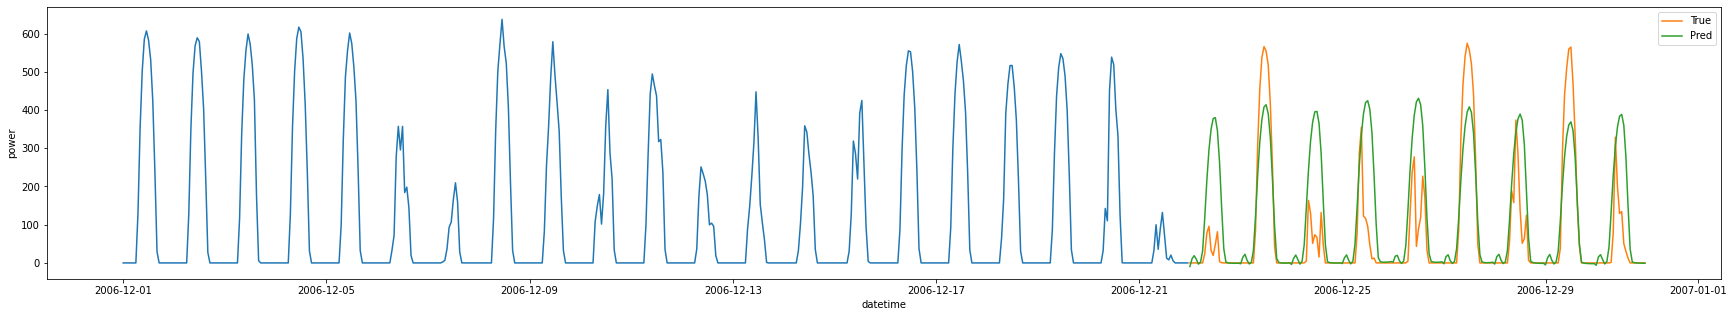

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()